In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

In [2]:
df_mortality = pd.read_csv('cleaned_mortality_data.csv')
df_incidence = pd.read_csv('cleaned_incidence_data.csv')

# 1. Moratlity

### 1.1 Test it out: AK, Alcohol

In [3]:
# Extract AK, Alcohol data from mortality dataframe
df_mortality_AK_ALC = df_mortality[(df_mortality['LocationAbbr'] == 'AK') & (df_mortality['TopicID'] == 'ALC')]
expData_mortality_AK_ALC = df_mortality_AK_ALC[['DataValueAlt','YearStart']]
expData_mortality_AK_ALC

,DataValueAlt,YearStart
0,9.9,2010
1,13.7,2011
2,12.2,2012
3,11.2,2013
4,11.4,2014
5,15.4,2015
6,16.7,2016
7,16.4,2017
8,16.4,2018
9,15.0,2019


In [4]:
# Reframe data for exponential smoothing
data = np.array(expData_mortality_AK_ALC)[:,0]
years = expData_mortality_AK_ALC['YearStart'].apply(lambda x: str(int(x)) + "-12-31")
years = pd.to_datetime(years)
years = np.array(years)
mort_data = pd.Series(data,years)
mort_data

2010-12-31     9.9
2011-12-31    13.7
2012-12-31    12.2
2013-12-31    11.2
2014-12-31    11.4
2015-12-31    15.4
2016-12-31    16.7
2017-12-31    16.4
2018-12-31    16.4
2019-12-31    15.0
2020-12-31    22.8
dtype: float64

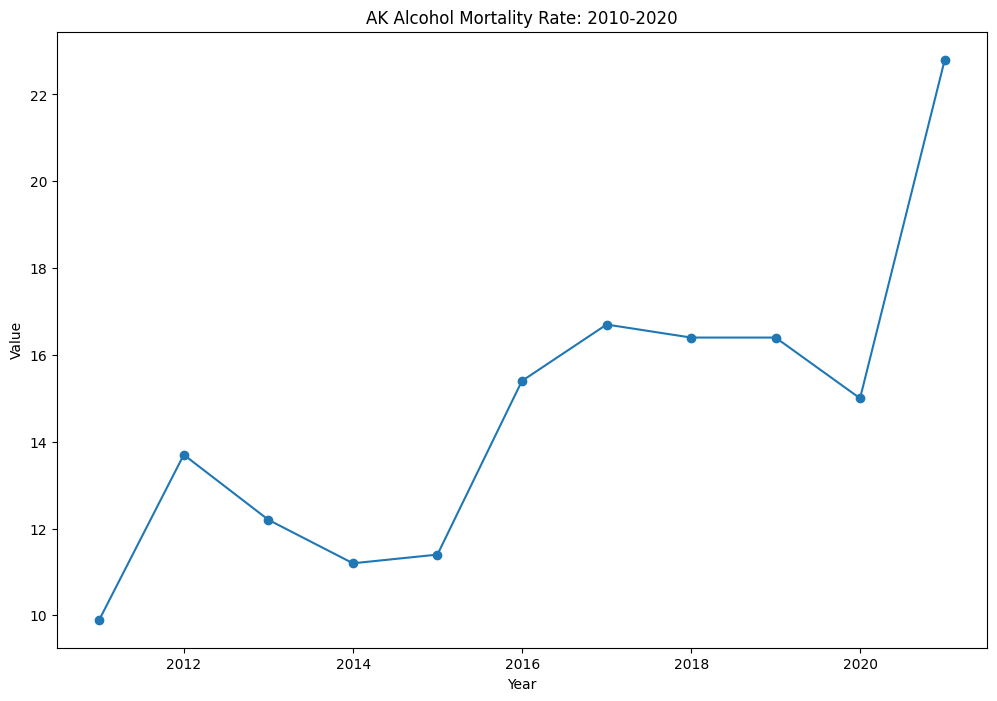

In [5]:
# plot data
plt.figure(figsize=(12, 8))
plt.plot(years, data, marker='o', linestyle='-')
plt.title('AK Alcohol Mortality Rate: 2010-2020')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)


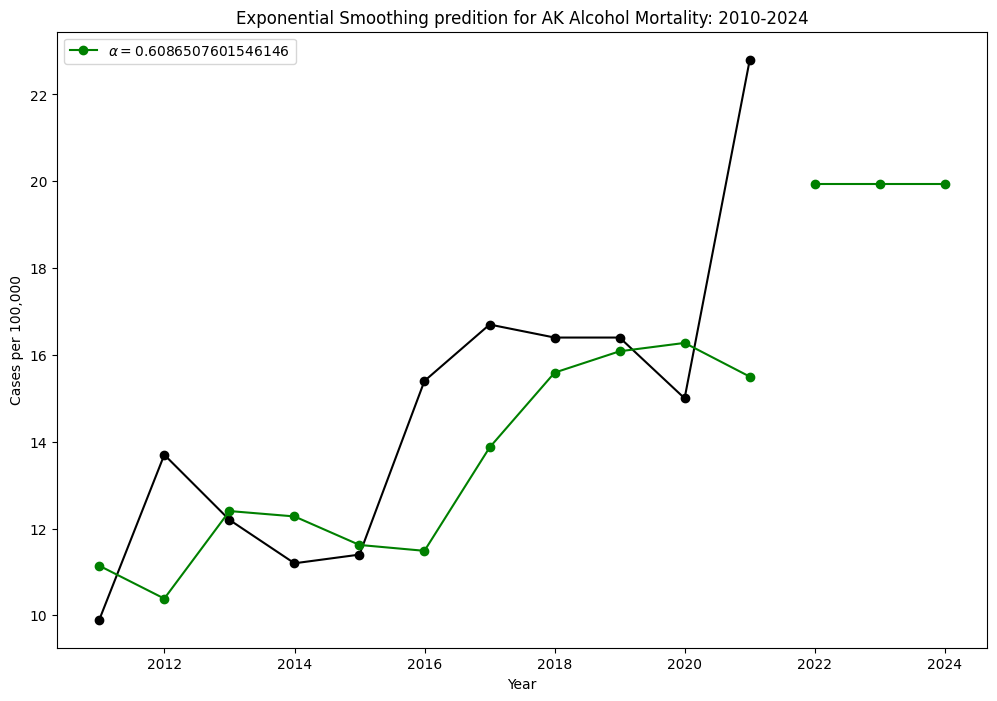

In [6]:
# Fit exponential smoothing (automoatic select best alpha)
fit3 = SimpleExpSmoothing(mort_data, initialization_method="estimated").fit()
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"]) # forecast rate for next 3 years (2022-2024)

# Plot fitted results with original data
plt.figure(figsize=(12, 8))
plt.plot(mort_data, marker="o", color="black")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line3], [fcast3.name])
plt.title('Exponential Smoothing predition for AK Alcohol Mortality: 2010-2024')
plt.xlabel('Year')
plt.ylabel('Cases per 100,000')
plt.show()

In [7]:
# calculate model MSE
y_true, y_pred = np.array(data), np.array(fit3.fittedvalues)
mean_squared_error(y_true, y_pred)

8.43527051446761

In [8]:
# calculate model R2
r2_score(y_true, y_pred)

0.2827554163968822

In [9]:
# calculate model MAPE
mean_absolute_percentage_error(y_true, y_pred)

0.12704319067474684

### 1.2 Full Model

In [10]:
# Extract useful columns from mortality dataframe
expData_mortality = df_mortality[['DataValueAlt','YearStart','LocationAbbr', 'TopicID', 'QuestionID']]
expData_mortality

,DataValueAlt,YearStart,LocationAbbr,TopicID,QuestionID
0,9.9,2010,AK,ALC,ALC6_0
1,13.7,2011,AK,ALC,ALC6_0
2,12.2,2012,AK,ALC,ALC6_0
3,11.2,2013,AK,ALC,ALC6_0
4,11.4,2014,AK,ALC,ALC6_0
...,...,...,...,...,...
7116,638.6,2016,WY,OVC,OVC5_0
7117,660.1,2017,WY,OVC,OVC5_0
7118,663.3,2018,WY,OVC,OVC5_0
7119,667.6,2019,WY,OVC,OVC5_0


In [11]:
# Store distinct location, topics, and questions
locs = np.array(expData_mortality.LocationAbbr.unique())
topics = np.array(expData_mortality.TopicID.unique())
questions = np.array(expData_mortality.QuestionID.unique())

In [12]:
# Fit model and store fitted models, forcasted values, and MSE for each model
fitted_models = {}
forcast_mortality = {}
mse_models = {}
r2_models = {}
mpe_models= {}

for loc in locs:
    for topic in topics:
        for question in questions:
            group_df = df_mortality[(df_mortality['LocationAbbr'] == loc) & (df_mortality['TopicID'] == topic) & (df_mortality['QuestionID'] == question)]
            group_df = group_df[['DataValueAlt','YearStart']]
            if not group_df.empty:
                string = '-'.join([loc,topic,question])
                data = np.array(group_df)[:,0]
                years = group_df['YearStart'].apply(lambda x: str(int(x)) + "-12-31")
                years = pd.to_datetime(years)
                years = np.array(years)
                mort_data = pd.Series(data,years)
                fit = SimpleExpSmoothing(mort_data, initialization_method="estimated").fit()
                fcast = fit.forecast(3).rename(r"$\alpha=%s$" % fit.model.params["smoothing_level"])
                y_true, y_pred = np.array(data), np.array(fit.fittedvalues)
                mse = mean_squared_error(y_true, y_pred)
                mpe = mean_absolute_percentage_error(y_true, y_pred)
                r2 = r2_score(y_true, y_pred)
                fitted_models[string] = fit
                forcast_mortality[string] = fcast
                mse_models[string] = mse
                r2_models[string] = r2
                mpe_models[string] = mpe

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
/Library/Framewo

In [13]:
# see stored results
print(fitted_models)
print(forcast_mortality)
print(mse_models)
print(r2_models)
print(mpe_models)

{'AK-ALC-ALC6_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14d3c7350>, 'AK-CVD-CVD1_5': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14d3573d0>, 'AK-CVD-CVD1_3': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14d3cda50>, 'AK-CVD-CVD1_2': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14d50d790>, 'AK-CVD-CVD1_4': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14d508490>, 'AK-CVD-CVD1_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14d4b4590>, 'AK-CKD-CKD1_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14d4b6750>, 'AK-COPD-COPD1_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14d3a71d0>, 'AK-COPD-COPD1_2': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14d525290>, 'AK-DIA-DIA1_1': <statsmodels.tsa.holtwinters.results.HoltW

In [14]:
#Average MSE for all mortality models
sum(mse_models.values())/len(mse_models.values())

163.55318222589304

In [15]:
#Average R2 for all mortality models
sum(r2_models.values())/len(r2_models.values())

0.3512869209468686

In [16]:
# Average MAPE for all mortality models
sum(mpe_models.values())/len(mpe_models.values())

0.0507556959436603

# 2. Incidence

In [17]:
# Extract useful columns from incidence dataframe
expData_incidence = df_incidence[['DataValueAlt','YearStart','LocationAbbr', 'TopicID', 'QuestionID']]
expData_incidence

,DataValueAlt,YearStart,LocationAbbr,TopicID,QuestionID
0,7.4,2011,AK,ALC,ALC5_1
1,6.6,2012,AK,ALC,ALC5_1
2,8.2,2013,AK,ALC,ALC5_1
3,8.8,2014,AK,ALC,ALC5_1
4,8.6,2015,AK,ALC,ALC5_1
...,...,...,...,...,...
7500,455.0,2016,WY,OLD,OLD1_0
7501,440.0,2017,WY,OLD,OLD1_0
7502,476.0,2018,WY,OLD,OLD1_0
7503,504.0,2019,WY,OLD,OLD1_0


In [18]:
# Store distinct location, topics, and questions
locs = np.array(expData_incidence.LocationAbbr.unique())
topics = np.array(expData_incidence.TopicID.unique())
questions = np.array(expData_incidence.QuestionID.unique())

In [19]:
# Fit model and store fitted models, forcasted values, and MSE for each model
fitted_models_incidence = {}
forcast_incidence = {}
mse_models_incidence = {}
r2_models_incidence = {}
mpe_models_incidence = {}

for loc in locs:
    for topic in topics:
        for question in questions:
            group_df = df_incidence[(df_incidence['LocationAbbr'] == loc) & (df_incidence['TopicID'] == topic) & (df_incidence['QuestionID'] == question)]
            group_df = group_df[['DataValueAlt','YearStart']]
            if not group_df.empty:
                string = '-'.join([loc,topic,question])
                data = np.array(group_df)[:,0]
                years = group_df['YearStart'].apply(lambda x: str(int(x)) + "-12-31")
                years = pd.to_datetime(years)
                years = np.array(years)
                mort_data = pd.Series(data,years)
                fit = SimpleExpSmoothing(mort_data, initialization_method="estimated").fit()
                fcast = fit.forecast(3).rename(r"$\alpha=%s$" % fit.model.params["smoothing_level"])
                y_true, y_pred = np.array(data), np.array(fit.fittedvalues)
                mse = mean_squared_error(y_true, y_pred)
                r2 = r2_score(y_true, y_pred)
                mpe = mean_absolute_percentage_error(y_true, y_pred)
                fitted_models_incidence[string] = fit
                forcast_incidence[string] = fcast
                mse_models_incidence[string] = mse
                r2_models_incidence[string] = r2
                mpe_models_incidence[string] = mpe

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
/Library/Framewo

In [20]:
# see stored results
print(fitted_models_incidence)
print(forcast_incidence)
print(mse_models_incidence)
print(r2_models_incidence)
print(mpe_models_incidence)

{'AK-ALC-ALC5_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14ef433d0>, 'AK-ART-ART1_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14ef6fe50>, 'AK-AST-AST1_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14ef7db10>, 'AK-CKD-CKD3_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14ef7f390>, 'AK-COPD-COPD2_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14ef6d3d0>, 'AK-DIA-DIA2_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14ef8dad0>, 'AK-DIS-DIS1_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14ef8f250>, 'AK-MTH-MTH2_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14ef94a90>, 'AK-NPAW-NPAW10_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x14ef96250>, 'AK-NPAW-NPAW1_1': <statsmodels.tsa.holtwinters.results.Ho

In [21]:
# Average MSE for all incidence models
sum(mse_models_incidence.values())/len(mse_models_incidence.values())

151168.66923175458

In [22]:
# Average R2 for all incidence models
sum(r2_models_incidence.values())/len(r2_models_incidence.values())

0.22571800581646864

In [23]:
# Average MAPE for all incidence models
sum(mpe_models_incidence.values())/len(mpe_models_incidence.values())

0.05498010380591786